In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from pathlib import Path
from tabulate import tabulate
from colorama import Fore, Style
import pickle

In [7]:
# 日志设置
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
plt.style.use('seaborn-v0_8-darkgrid')

In [8]:
def run_discrete_backtest(data, initial_capital=100000, commission_rate=0.0002):
    """
    离散事件驱动的回测系统，每笔交易独立持仓10个周期
    
    参数:
    - data (pd.DataFrame): 包含'signal'和'close'列的数据
    - initial_capital (float): 初始资金
    - commission_rate (float): 交易手续费率
    
    返回:
    - pd.DataFrame: 回测结果
    - float: 与简单策略的相关系数
    """
    logging.info("🤖 开始离散事件驱动回测...")
    
    # 复制数据避免修改原始数据
    df = data.copy()
    
    # 初始化结果列
    df['position'] = 0        # 当前持仓方向
    df['trade_pnl'] = 0.0     # 当期平仓盈亏
    df['open_price'] = np.nan # 开仓价格
    df['close_price'] = np.nan # 平仓价格
    df['trade_duration'] = 0  # 交易持仓周期数
    
    # 用于存储活跃交易
    active_trades = []
    
    # 遍历每个时间点
    for i in range(len(df)):
        current_time = df.index[i]
        current_close = df['close'].iloc[i]
        current_signal = df['signal'].iloc[i]
        
        # 1. 处理到期交易 (持仓满10个周期)
        for trade in active_trades[:]:
            trade_duration = i - trade['open_index']
            
            if trade_duration >= 10:
                # 平仓逻辑
                direction = trade['direction']
                open_price = trade['open_price']
                
                # 计算盈亏 (单利计算)
                price_change = current_close - open_price
                pnl = direction * price_change
                
                # 扣除手续费 (双边)
                commission = commission_rate * (open_price + current_close)
                net_pnl = pnl - commission
                
                # 记录交易结果
                df.at[current_time, 'trade_pnl'] += net_pnl
                df.at[current_time, 'position'] -= direction
                
                # 记录交易详情
                if np.isnan(df.at[current_time, 'open_price']):
                    df.at[current_time, 'open_price'] = open_price
                    df.at[current_time, 'close_price'] = current_close
                    df.at[current_time, 'trade_duration'] = trade_duration
                else:
                    # 如果同一时间有多个交易平仓，取平均值
                    df.at[current_time, 'open_price'] = (
                        df.at[current_time, 'open_price'] + open_price) / 2
                    df.at[current_time, 'close_price'] = (
                        df.at[current_time, 'close_price'] + current_close) / 2
                    df.at[current_time, 'trade_duration'] = (
                        df.at[current_time, 'trade_duration'] + trade_duration) / 2
                
                # 从活跃交易中移除
                active_trades.remove(trade)
        
        # 2. 处理新开仓交易
        if current_signal != 0:
            # 开仓逻辑
            trade = {
                'open_time': current_time,
                'open_price': current_close,
                'open_index': i,
                'direction': current_signal
            }
            active_trades.append(trade)
            
            # 更新持仓
            df.at[current_time, 'position'] += current_signal
    
    # 处理回测结束时仍未平仓的交易
    for trade in active_trades:
        close_index = min(trade['open_index'] + 10, len(df) - 1)
        close_time = df.index[close_index]
        close_price = df['close'].iloc[close_index]
        
        # 计算盈亏
        direction = trade['direction']
        open_price = trade['open_price']
        price_change = close_price - open_price
        pnl = direction * price_change
        commission = commission_rate * (open_price + close_price)
        net_pnl = pnl - commission
        
        # 记录交易结果
        df.at[close_time, 'trade_pnl'] += net_pnl
        df.at[close_time, 'position'] -= direction
    
    # 计算累计盈亏和权益曲线
    df['cumulative_pnl'] = df['trade_pnl'].cumsum()
    df['equity_curve'] = initial_capital + df['cumulative_pnl']
    
    # 计算每日收益率 (用于相关性分析)
    df['return'] = df['close'].pct_change()
    
    # 计算简单策略的累计收益
    df['simple_strategy'] = (df['signal'].shift(1) * df['return']).cumsum()
    
    # 计算相关性
    correlation = df['cumulative_pnl'].corr(df['simple_strategy'])
    
    logging.info("🎉 离散事件驱动回测完成")
    return df, correlation

In [9]:
def evaluate_performance(backtest_results, correlation):
    """
    简化的性能评估函数
    """
    equity_curve = backtest_results['equity_curve']
    cumulative_pnl = backtest_results['cumulative_pnl']
    
    # 计算关键指标
    total_return = cumulative_pnl.iloc[-1]
    max_equity = equity_curve.cummax()
    drawdown = (equity_curve - max_equity) / max_equity
    max_drawdown = drawdown.min()
    
    # 计算年化收益率
    days = (equity_curve.index[-1] - equity_curve.index[0]).days
    annualized_return = (total_return / days) * 365 if days > 0 else 0
    
    # 交易统计
    trade_results = backtest_results[backtest_results['trade_pnl'] != 0]
    winning_trades = trade_results[trade_results['trade_pnl'] > 0]
    losing_trades = trade_results[trade_results['trade_pnl'] < 0]
    
    total_trades = len(trade_results)
    win_rate = len(winning_trades) / total_trades if total_trades > 0 else 0
    avg_win = winning_trades['trade_pnl'].mean() if not winning_trades.empty else 0
    avg_loss = losing_trades['trade_pnl'].mean() if not losing_trades.empty else 0
    profit_factor = abs(winning_trades['trade_pnl'].sum() / losing_trades['trade_pnl'].sum()) if not losing_trades.empty else np.inf
    
    # 打印报告
    print("\n" + "="*80)
    print(Fore.CYAN + " " * 30 + "策略性能评估报告" + " " * 30 + Style.RESET_ALL)
    print("="*80)
    
    # 核心指标
    headers = ["指标", "值"]
    table = [
        ["总盈亏", f"{total_return:,.2f}"],
        ["年化收益率", f"{annualized_return:.2%}"],
        ["最大回撤", f"{max_drawdown:.2%}"],
        ["胜率", f"{win_rate:.2%}"],
        ["盈亏比", f"{profit_factor:.2f}"],
        ["平均盈利", f"{avg_win:.2f}"],
        ["平均亏损", f"{avg_loss:.2f}"],
        ["总交易次数", total_trades],
        ["与简单策略相关系数", f"{correlation:.6f}"]
    ]
    print(tabulate(table, headers=headers, tablefmt="grid", stralign="center"))
    
    # 绘制权益曲线
    plt.figure(figsize=(15, 7))
    equity_curve.plot(title='策略权益曲线', lw=2, color='royalblue')
    plt.ylabel('资金')
    plt.xlabel('日期')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    return {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'profit_factor': profit_factor,
        'correlation': correlation
    }

2025-07-23 21:20:18,351 - INFO - 📂 加载数据: /public/data/_test_backtest_intern.pkl
2025-07-23 21:20:18,353 - INFO - 🤖 开始离散事件驱动回测...
2025-07-23 21:20:27,696 - INFO - 🎉 离散事件驱动回测完成



                              策略性能评估报告                              
+--------------------+--------------+
|        指标        |      值      |
+====================+==============+
|       总盈亏       | -218,253.06  |
+--------------------+--------------+
|     年化收益率     | -5806294.88% |
+--------------------+--------------+
|      最大回撤      |   -296.84%   |
+--------------------+--------------+
|        胜率        |    47.80%    |
+--------------------+--------------+
|       盈亏比       |     0.95     |
+--------------------+--------------+
|      平均盈利      |    311.54    |
+--------------------+--------------+
|      平均亏损      |   -300.80    |
+--------------------+--------------+
|     总交易次数     |    26858     |
+--------------------+--------------+
| 与简单策略相关系数 |  -0.370300   |
+--------------------+--------------+


/home/wj/miniconda3/envs/cta_v1/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36164 (\N{CJK UNIFIED IDEOGRAPH-8D44}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/wj/miniconda3/envs/cta_v1/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/wj/miniconda3/envs/cta_v1/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31574 (\N{CJK UNIFIED IDEOGRAPH-7B56}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/wj/miniconda3/envs/cta_v1/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30053 (\N{CJK UNIFIED IDEOGRAPH-7565}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/wj/miniconda3/envs/cta_v1/lib/python3.11/site-packages/IPython/core/pylabtools.py:170:

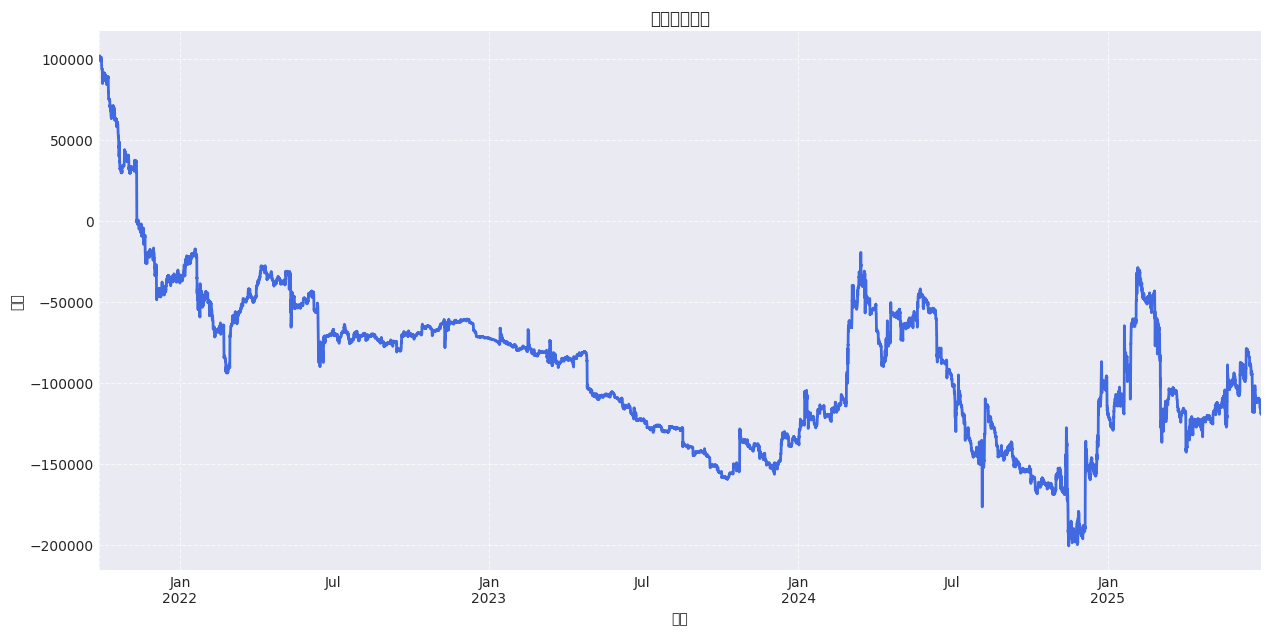

2025-07-23 21:20:30,066 - INFO - 💾 回测结果已保存至: discrete_backtest_results.csv



关键结果摘要:
最终权益: -118,253.06
总盈亏: -218,253.06
与简单策略(signal*return)的相关系数: -0.370300


In [10]:
# 主程序
if __name__ == '__main__':
    # 参数配置
    FILE_PATH = "/public/data/_test_backtest_intern.pkl"
    INITIAL_CAPITAL = 100000
    COMMISSION_RATE = 0.0002
    
    # 加载数据
    logging.info(f"📂 加载数据: {FILE_PATH}")
    with open(FILE_PATH, 'rb') as f:
        data = pickle.load(f)
    
    # 运行离散事件回测
    backtest_results, correlation = run_discrete_backtest(
        data, 
        initial_capital=INITIAL_CAPITAL,
        commission_rate=COMMISSION_RATE
    )
    
    # 评估性能
    performance = evaluate_performance(backtest_results, correlation)
    
    # 保存结果
    output_path = "discrete_backtest_results.csv"
    backtest_results.to_csv(output_path)
    logging.info(f"💾 回测结果已保存至: {output_path}")
    
    # 打印关键结果
    print("\n" + "="*80)
    print(Fore.GREEN + "关键结果摘要:" + Style.RESET_ALL)
    print(f"最终权益: {backtest_results['equity_curve'].iloc[-1]:,.2f}")
    print(f"总盈亏: {performance['total_return']:,.2f}")
    print(f"与简单策略(signal*return)的相关系数: {performance['correlation']:.6f}")